In [2]:
#https://notebook.community/mas-dse-greina/neon/dicom/DICOM%20Processing%20Script - code taken from here

from matplotlib import pyplot as plt, cm
from PIL import Image, ImageEnhance
import numpy as np
import glob, os
import h5py
import ntpath
import SimpleITK as sitk
import cv2
import random
import pydicom
import sigpy as sp
import sigpy.plot as pl
import sigpy.mri as mr
from pydicom.pixel_data_handlers.util import apply_voi_lut

%matplotlib inline


DATA_DIR = "C:/Users/Kevin/Desktop/patient data/original/train"
DATA_DIR_TESTING = "C:/Users/Kevin/Desktop/patient data/original/test"
DATA_DIR_MASK_TRAIN = "C:/Users/Kevin/Desktop/patient data/mask/train"
DATA_DIR_MASK_TEST = "C:/Users/Kevin/Desktop/patient data/mask/test"

patients = glob.glob(os.path.join(DATA_DIR, '*')) # Get the folder names for the patients - for training
patients_testing = glob.glob(os.path.join(DATA_DIR_TESTING, '*'))
patients_training_mask = glob.glob(os.path.join(DATA_DIR_MASK_TRAIN, '*')) # Get the folder names for the patients - for training
patients_testing_mask = glob.glob(os.path.join(DATA_DIR_MASK_TEST, '*'))



def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


def makeCSM(path, num_of_coils = 1):
#path is just the path of the jpeg you'll be passing through after you create it from the dicom. 
#this function makes the CSM images. 
    
    gradient_magnitude = 1.2
    faded_arr = []
    iteration_angle = 360/(num_of_coils)
    
    for i in range(num_of_coils):
        im = Image.open(path).convert("L").rotate(270+(i*iteration_angle))
        if im.mode != 'RGBA':
            im = im.convert('RGBA')
        width, height = im.size
        gradient = Image.new('L', (width, 1), color=0xFF)
        for x in range(width):
            # gradient.putpixel((x, 0), 255-x)
            gradient.putpixel((x, 0), int(255 * (1.2 - gradient_magnitude * float(x)/width)))
        alpha = gradient.resize(im.size)
        black_im = Image.new('RGBA', (width, height), color=0) # i.e. black
        black_im.putalpha(alpha)
        gradient_im = Image.alpha_composite(im, black_im)

        #increases contrast of image
        enhancer = ImageEnhance.Contrast(gradient_im)
        gradient_im = enhancer.enhance(2.5)

        #converts image to greyscale
        gradient_im = gradient_im.convert('L').rotate(90-(i*iteration_angle))
        
        #creates numpy array from image
        np_arr = np.array(gradient_im)
        
        #FFT conversion
        img_fft = np.fft.fftshift(np_arr)
        img_fft = np.fft.fft2(img_fft)
        
        #pushes each image np.array into larger array
        if i == 0:
            faded_arr = np.expand_dims(img_fft, axis = 0)
        else:
            faded_arr = np.append(faded_arr, np.expand_dims(img_fft, axis = 0), axis = 0)
    
            
    #here begins CSM estimations - prepares FFT for CSM esitmation
    ksp = faded_arr
    temp = []

    for i in range(num_of_coils):
        ksp_arr = []
        ksp_arr = ksp[i]
        ksp_arr = np.fft.fftshift(ksp[i])
        if i == 0:
            temp = np.expand_dims(ksp_arr, axis = 0)
        else:
            temp = np.append(temp, np.expand_dims(ksp_arr, axis = 0), axis = 0)

    ksp = temp
        
    #plots the k-spaces 
    #pl.ImagePlot(ksp, mode='l', z=0, title='k-space')
        
    mps = mr.app.EspiritCalib(ksp).run()
    
    #print(mps.shape)

    #pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
            
        #prints image out
        #following commented code is only for diagnosis
        
#         plt.imshow(img_fft.astype("float64"))
#         plt.show()
        
#         #prints shape
#         print(np_arr.shape)

#         #saves image as file
#         gradient_im.save('C:/Users/Kevin/Desktop/old/test/out' + str(i) + '.png', 'PNG')

    return mps


def getImageTensor(patientDirectory):
    """
    Helper function for injesting all of the DICOM files for one study into a single tensor
    
    input: 'patientDirectory', the directory where the DICOMs for a single patient are stored
    outputs:
            imgTensor = a flattened numpy array (1, C*H*W*D)
            C = number of channels per pixel (1 for MR, CT, and Xray)
            H = number of pixels in height
            W = number of pixels in width
            D = number of pixels in depth
    """
    
    imgTensor = []
    reader = sitk.ImageSeriesReader()  # Set up the reader object
    
    print(patientDirectory)
    
    ##for imgTensor
    for patientDirectory in patients[:1]:
        print("Assembling trnOrg files... \n")
        # Now get the names of the DICOM files within the directory
        filenamesDICOM = reader.GetGDCMSeriesFileNames(patientDirectory)
        reader.SetFileNames(filenamesDICOM)
        # Now execute the reader pipeline
        patientObject = reader.Execute() 

        imgTensor = sitk.GetArrayFromImage(patientObject)
        
    for patientDirectory in patients[1:]:
        # Now get the names of the DICOM files within the directory
        filenamesDICOM = reader.GetGDCMSeriesFileNames(patientDirectory)
        reader.SetFileNames(filenamesDICOM)
        # Now execute the reader pipeline
        patientObject = reader.Execute()

        C = patientObject.GetNumberOfComponentsPerPixel() # There is just one color channel in the DICOM for CT and MRI
        H = patientObject.GetHeight()  # Height in pixels
        W = patientObject.GetWidth()   # Width in pixels
        D = patientObject.GetDepth()  # Depth in pixels

        imgTensor = np.append(imgTensor, sitk.GetArrayFromImage(patientObject), axis=0)
        
        
    print("Done assembling trnOrg files! \n")
        
    ##for imgTensorCSM
    imgTensorCSM = []
    number_of_coils = 1
        
    print("Assembling trnCsm files... \n")
    
    for j in range(0,len(patients)):
        DATA_DIR_TRNCSM = patients[j]
        patients_images = glob.glob(os.path.join(DATA_DIR_TRNCSM, '*'))
        CSMtemp = []

        for i in range(0,1):#len(patients_testing)):
            ds = read_xray(patients_images[i])
            im = Image.fromarray(ds)
            filename = "C:/Users/Kevin/Desktop/patient data/temp storage/file-out " + str(i) + ".jpeg"
            im.save(filename)
            array_with_fft_applied = makeCSM(filename, number_of_coils)
            os.remove(filename)
            if i == 0:
                CSMtemp = np.expand_dims(array_with_fft_applied, axis = 0)
            else:
                CSMtemp = np.append(CSMtemp, np.expand_dims(array_with_fft_applied, axis = 0), axis = 0)
                print("image number " + str(i+1) + " done!")
                
        if j == 0:
            imgTensorCSM = CSMtemp
        else:
            imgTensorCSM = np.append(imgTensorCSM, CSMtemp, axis = 0)
        
        
                
    print(imgTensorCSM.shape)
    

    print("Done assembling trnCsm files! \n")
               
    
    return imgTensor, imgTensorCSM, C, H, W, D


def getImageTensor_mask(patients_training_mask_var, patients_testing_mask_var):
    
    training_mask = []
    testing_mask = []

    #for training
    print("Assembling trnMask files... \n")
    for patientDirectory in patients_training_mask_var[:1]:
        image = Image.open(patientDirectory).convert('L')
        img_arr = np.array(image)
        training_mask = np.expand_dims(img_arr, axis = 0)


    for patientDirectory in patients_training_mask_var[1:]:
        image = Image.open(patientDirectory).convert('L')
        img_arr = np.array(image)
        training_mask = np.append(training_mask, np.expand_dims(img_arr, axis = 0), axis = 0)
    print(training_mask.shape)
    print("Done assembling trnMask files! \n")


    #for testing
    print("Assembling tstMask files... \n")
    for patientDirectory in patients_testing_mask_var[:1]:
        image = Image.open(patientDirectory).convert('L')
        img_arr = np.array(image)
        img_arr = img_arr.astype("float64")
        testing_mask = np.expand_dims(img_arr, axis = 0)


    for patientDirectory in patients_testing_mask_var[1:]:
        image = Image.open(patientDirectory).convert('L')
        img_arr = np.array(image)
        img_arr = img_arr.astype("float64")
        testing_mask = np.append(testing_mask, np.expand_dims(img_arr, axis = 0), axis = 0)
    print(testing_mask.shape)
    print("Done assembling tstMask files! \n")
    
    return training_mask, testing_mask


def getImageTensor_test(patientDirectory):
    """
    Helper function for injesting all of the DICOM files for one study into a single tensor
    
    input: 'patientDirectory', the directory where the DICOMs for a single patient are stored
    outputs:
            imgTensor = a flattened numpy array (1, C*H*W*D)
            C = number of channels per pixel (1 for MR, CT, and Xray)
            H = number of pixels in height
            W = number of pixels in width
            D = number of pixels in depth
    """
    
    imgTensor = []
    reader = sitk.ImageSeriesReader()  # Set up the reader object
    
    ##for imgTensor
    for patientDirectory in patients_testing[:1]:
        print("Assembling tstOrg files... \n")
        # Now get the names of the DICOM files within the directory
        filenamesDICOM = reader.GetGDCMSeriesFileNames(patientDirectory)
        reader.SetFileNames(filenamesDICOM)
        # Now execute the reader pipeline
        patientObject = reader.Execute() 

        imgTensor = sitk.GetArrayFromImage(patientObject)
        
    for patientDirectory in patients_testing[1:]:
        # Now get the names of the DICOM files within the directory
        filenamesDICOM = reader.GetGDCMSeriesFileNames(patientDirectory)
        reader.SetFileNames(filenamesDICOM)
        # Now execute the reader pipeline
        patientObject = reader.Execute()

        C = patientObject.GetNumberOfComponentsPerPixel() # There is just one color channel in the DICOM for CT and MRI
        H = patientObject.GetHeight()  # Height in pixels
        W = patientObject.GetWidth()   # Width in pixels
        D = patientObject.GetDepth()  # Depth in pixels

        imgTensor = np.append(imgTensor, sitk.GetArrayFromImage(patientObject), axis=0)
        
    print("Done assembling tstOrg files! \n")
        
   
    ##for imgTensorCSM 
    ##preparing for CSM coil approximation 
    imgTensorCSM = []
    number_of_coils = 1
    
    for j in range(0,1):#len(patients_testing)):
        DATA_DIR_TSTCSM = patients_testing[j]
        patients_images = glob.glob(os.path.join(DATA_DIR_TSTCSM, '*'))
        CSMtemp = []

        for i in range(0,len(patients_images)):
            ds = read_xray(patients_images[i])
            im = Image.fromarray(ds)
            filename = "C:/Users/Kevin/Desktop/patient data/temp storage/file-out " + str(i) + ".jpeg"
            im.save(filename)
            array_with_fft_applied = makeCSM(filename, number_of_coils)
            os.remove(filename)
            if i == 0:
                CSMtemp = np.expand_dims(array_with_fft_applied, axis = 0)
            else:
                CSMtemp = np.append(CSMtemp, np.expand_dims(array_with_fft_applied, axis = 0), axis = 0)
        
        if j == 0:
            imgTensorCSM = CSMtemp
        else:
            imgTensorCSM = np.append(imgTensorCSM, CSMtemp, axis = 0)
        
                
    plt.imshow(imgTensorCSM[0][0].astype("float64"))
    plt.show()
    print(imgTensorCSM.shape)

    print("Done assembling tstCsm files! \n")
               
    
    return imgTensor, imgTensorCSM, C, H, W, D



#################################################################################################
#where the magic happens



Compiling HDF5 dataset file now... 

['C:/Users/Kevin/Desktop/patient data/original/train\\11.000000-T1post-04208', 'C:/Users/Kevin/Desktop/patient data/original/train\\11.000000-T1post-24727', 'C:/Users/Kevin/Desktop/patient data/original/train\\11.000000-T1post-36303', 'C:/Users/Kevin/Desktop/patient data/original/train\\11.000000-T1post-45042', 'C:/Users/Kevin/Desktop/patient data/original/train\\12.000000-T1post-03514', 'C:/Users/Kevin/Desktop/patient data/original/train\\13.000000-T1post-77241', 'C:/Users/Kevin/Desktop/patient data/original/train\\14.000000-T1post-22014', 'C:/Users/Kevin/Desktop/patient data/original/train\\15.000000-T1post-68979', 'C:/Users/Kevin/Desktop/patient data/original/train\\37974.000000-T2reg-50744', 'C:/Users/Kevin/Desktop/patient data/original/train\\37980.000000-T2reg-88079', 'C:/Users/Kevin/Desktop/patient data/original/train\\37982.000000-T2reg-54614', 'C:/Users/Kevin/Desktop/patient data/original/train\\37996.000000-T2reg-91397', 'C:/Users/Kevin/De

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(16, 1, 512, 512)
Done assembling trnCsm files! 

Assembling tstOrg files... 

Done assembling tstOrg files! 



EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Kevin\AppData\Local\Temp/ipykernel_32712/4265379274.py:334: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(imgTensorCSM[0][0].astype("float64"))


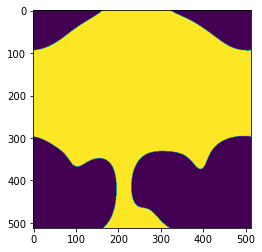

(22, 1, 512, 512)
Done assembling tstCsm files! 

Assembling trnMask files... 

(368, 512, 512)
Done assembling trnMask files! 

Assembling tstMask files... 

(180, 512, 512)
Done assembling tstMask files! 

Done! Dataset created.


In [6]:
print("Compiling HDF5 dataset file now... \n")

outFilename = 'dicom_out.hdf5'  # The name of our HDF5 data file

with h5py.File(outFilename, 'w') as df:  # Open hdf5 file for writing our DICOM dataset

    numPatients = len(patients)  # Number of patients in the directory
        
   
    imgTensor, imgTensorCSM, original_C, original_H, original_W, original_D = getImageTensor(patients)
    imgTensor_test, imgTensorCSM_test, original_C, original_H, original_W, original_D = getImageTensor_test(patients_testing)
    imgTensor_mask_train, imgTensor_mask_test = getImageTensor_mask(patients_training_mask, patients_testing_mask)

    
    
    ##managing datatypes
    c8_datatype = np.dtype('<c8')
    i1_datatype = np.dtype('|i1') 
    
    #for training
    dset = df.create_dataset('trnOrg', data=imgTensor.astype(c8_datatype), shape=(368,512,512), maxshape=(None, 512,512))
    dset = df.create_dataset('trnCsm', data=imgTensorCSM.astype(c8_datatype), shape=(16,1,512,512), maxshape=(None, None, 512,512))
    dset = df.create_dataset('trnMask',data=imgTensor_mask_train.astype(i1_datatype), shape=(368,512,512), maxshape=(None, 512,512))

    
    #for testing
    dset = df.create_dataset('tstOrg', data=imgTensor_test.astype(c8_datatype), shape=(180,512,512), maxshape=(None, 512,512))
    dset = df.create_dataset('tstCsm', data=imgTensorCSM_test.astype(c8_datatype), shape=(22,1,512,512), maxshape=(None, None, 512,512))
    dset = df.create_dataset('tstMask',data=imgTensor_mask_test.astype(i1_datatype), shape=(180,512,512), maxshape=(None, 512,512))

    
    print("Done! Dataset created.")
            
